# **Cell 1** — Install deps (Colab-safe) & check GPU

In [3]:
# !nvidia-smi -L || print("⚠️ No GPU detected. Go to Runtime > Change runtime type > GPU.")
!nvidia-smi -L
!pip -q uninstall -y cudf-cu12 dask-cudf-cu12 cuml-cu12 pylibcudf-cu12 rmm-cu12 ucx-py ucxx rapids-dask-dependency || true
!pip -q install -U pandas==2.2.2 pyarrow==21.0.0
!pip -q install -U transformers datasets accelerate sentence-transformers scikit-learn

GPU 0: Tesla T4 (UUID: GPU-f2a9b1ab-e95c-e57f-7a4e-f5683c3ab51a)


# **Cell 2** — (Optional) Mount Google Drive

In [4]:
from google.colab import drive
USE_DRIVE = False   # set False if you don’t want Drive
drive.mount('/content/drive')
if USE_DRIVE:
    SAVE_DIR = "/content/drive/MyDrive/Dataset/colab_runs"
else:
    SAVE_DIR = "/content/baitbuster_runs"

import os; os.makedirs(SAVE_DIR, exist_ok=True)
print("Saving to:", SAVE_DIR)


Mounted at /content/drive
Saving to: /content/baitbuster_runs


# **Cell 3** — Load full dataset (CSV/Parquet/XLSX)

In [5]:
import pandas as pd, os

CSV_PATH     = "/content/drive/MyDrive/Dataset/BaitBuster-Bangla_253070_18c_HL10k_AIL.csv"
PARQUET_PATH = "/content/drive/MyDrive/Dataset/BaitBuster-Bangla_253070_18c_HL10k_AIL.parquet"
XLSX_PATH    = "/content/drive/MyDrive/Dataset/BaitBuster-Bangla_253070_18c_HL10k_AIL.xlsx"

if   os.path.exists(CSV_PATH):     df_all = pd.read_csv(CSV_PATH)
elif os.path.exists(PARQUET_PATH): df_all = pd.read_parquet(PARQUET_PATH)
elif os.path.exists(XLSX_PATH):    df_all = pd.read_excel(XLSX_PATH)
else: raise FileNotFoundError("Upload the dataset and update the path(s).")

print("Columns:", list(df_all.columns)[:25])
print("Rows:", len(df_all))


Columns: ['channel_id', 'channel_name', 'channel_url', 'video_id', 'publishedAt', 'title', 'title_debiased', 'description', 'description_debiased', 'url', 'viewCount', 'commentCount', 'likeCount', 'dislikeCount', 'thumbnail', 'auto_labeled', 'human_labeled', 'ai_labeled']
Rows: 253070


# **Cell 4**— Preprocessing: normalize labels, choose columns, clean

In [6]:
import numpy as np

# prefer debiased fields if available
TITLE_COL = "title_debiased" if "title_debiased" in df_all.columns else "title"
DESC_COL  = "description_debiased" if "description_debiased" in df_all.columns else "description"

assert TITLE_COL in df_all.columns, f"Missing {TITLE_COL}"
assert DESC_COL  in df_all.columns, f"Missing {DESC_COL}"

# normalize human labels (gold subset)
lab = df_all.get("human_labeled")
assert lab is not None, "Dataset lacks 'human_labeled' column."

lab = lab.astype(str).str.strip().str.lower().replace({
    "not_clickbait":"not clickbait","non-clickbait":"not clickbait","non_clickbait":"not clickbait",
    "notclickbait":"not clickbait","click bait":"clickbait","yes":"clickbait","no":"not clickbait",
    "1":"clickbait","0":"not clickbait"
})
mask = lab.isin(["clickbait","not clickbait"])
df = df_all.loc[mask, [TITLE_COL, DESC_COL, "human_labeled"]].copy()

# drop completely empty texts
df[TITLE_COL] = df[TITLE_COL].astype(str).str.strip()
df[DESC_COL]  = df[DESC_COL].astype(str) .str.strip()

# fallback short description if empty
df.loc[df[DESC_COL].eq(""), DESC_COL] = "[EMPTY]"

# binary label
df["label"] = (lab[mask] == "clickbait").astype(int)

print("Kept rows (human-labeled):", len(df))
print("Label balance 0/1:", np.bincount(df["label"]))
df[[TITLE_COL, DESC_COL, "label"]].head()

Kept rows (human-labeled): 10000
Label balance 0/1: [4356 5644]


,title_debiased,description_debiased,label
0,এইমাত্র! মসজিদে নামাজরত অবস্থায় তিন বৃদ্ধকে পি...,ভিডিওটি লাগলে লাইক দিন ও সবাইকে দেখার সুযোগ কর...,1
1,"১০ বছরের সন্তান ফেলে আ,লীগ নেতার সাথে পালিয়ে গ...",ভিডিওটি লাগলে লাইক দিন ও সবাইকে দেখার সুযোগ কর...,1
2,এই মাত্র পাওয়া খবর! ৫ বছরের জেল হচ্ছে পরীমনির!...,ভিডিওটি লাগলে লাইক দিন ও সবাইকে দেখার সুযোগ কর...,1
3,ছি ছি! ভাগিনার সাথে পরকীয়ার সময় হাতেনাতে ধরা খ...,ভিডিওটি লাগলে লাইক দিন ও সবাইকে দেখার সুযোগ কর...,1
4,হায়রে পরীমনি! কারাগারে গিয়েও ভালো হলোনা! কারাগ...,ভিডিওটি লাগলে লাইক দিন ও সবাইকে দেখার সুযোগ কর...,1


# **Cell 5** — Train/Val/Test split (60/20/20 stratified)

In [7]:
from sklearn.model_selection import train_test_split

X_title = df[TITLE_COL].tolist()
X_desc  = df[DESC_COL].tolist()
y       = df["label"].values

train_idx, temp_idx = train_test_split(
    np.arange(len(df)), test_size=0.4, stratify=y, random_state=42
)
val_idx, test_idx = train_test_split(
    temp_idx, test_size=0.5, stratify=y[temp_idx], random_state=42
)

def take(idx):
    return [X_title[i] for i in idx], [X_desc[i] for i in idx], y[idx]

Xtr_t, Xtr_d, ytr = take(train_idx)
Xva_t, Xva_d, yva = take(val_idx)
Xte_t, Xte_d, yte = take(test_idx)

print("Train/Val/Test sizes:", len(ytr), len(yva), len(yte))
print("Train balance:", np.bincount(ytr))
print("Val   balance:", np.bincount(yva))
print("Test  balance:", np.bincount(yte))

Train/Val/Test sizes: 6000 2000 2000
Train balance: [2614 3386]
Val   balance: [ 871 1129]
Test  balance: [ 871 1129]


# **Cell 6** — Build Hugging Face Datasets for dual inputs

In [8]:
from datasets import Dataset

def make_ds(titles, descs, labels):
    return Dataset.from_dict({
        "title": titles,
        "desc":  descs,
        "label": labels.tolist() if isinstance(labels, np.ndarray) else labels
    })

train_ds = make_ds(Xtr_t, Xtr_d, ytr)
val_ds   = make_ds(Xva_t, Xva_d, yva)
test_ds  = make_ds(Xte_t, Xte_d, yte)

len(train_ds), len(val_ds), len(test_ds)

(6000, 2000, 2000)

# **Cell 7** — Tokenizers for BanglaBERT (title + desc)

In [9]:
from transformers import AutoTokenizer

MODEL_NAME = "csebuetnlp/banglabert"  # you can switch to "sagorsarker/bangla-bert-base"
tok = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

MAX_T_LEN = 128
MAX_D_LEN = 256

def tok_dual(batch):
    t = tok(batch["title"], truncation=True, padding="max_length", max_length=MAX_T_LEN)
    d = tok(batch["desc"],  truncation=True, padding="max_length", max_length=MAX_D_LEN)
    return {
        "title_input_ids": t["input_ids"],
        "title_attention_mask": t["attention_mask"],
        "desc_input_ids": d["input_ids"],
        "desc_attention_mask": d["attention_mask"],
        "labels": batch["label"],
    }

train_tok = train_ds.map(tok_dual, batched=True, remove_columns=train_ds.column_names)
val_tok   = val_ds.map(tok_dual,   batched=True, remove_columns=val_ds.column_names)
test_tok  = test_ds.map(tok_dual,  batched=True, remove_columns=test_ds.column_names)

train_tok.set_format(type="torch")
val_tok.set_format(type="torch")
test_tok.set_format(type="torch")

train_tok[0]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/586 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

{'title_input_ids': tensor([    2,   830,  1768,     1,     5,  3761, 14001,     1,  1990,  1042,
           831,  2097,  7316, 14749,  1945,   205,     1,     1,  4255,   834,
             3,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,    

# **Cell 8** — Dual BanglaBERT + Fusion head (PyTorch model)

In [10]:
import torch, torch.nn as nn
from transformers import AutoModel, AutoConfig

class DualBanglaBERT(nn.Module):
    def __init__(self, model_name=MODEL_NAME, num_labels=2, dropout=0.3,
                 share_weights=False, freeze_lower_n_layers=0):
        super().__init__()
        cfg = AutoConfig.from_pretrained(model_name)
        self.num_labels = num_labels

        # Either share the same encoder or instantiate two
        self.title_encoder = AutoModel.from_pretrained(model_name, config=cfg)
        if share_weights:
            self.desc_encoder = self.title_encoder  # weight sharing
        else:
            self.desc_encoder = AutoModel.from_pretrained(model_name, config=cfg)

        self.hidden = cfg.hidden_size
        self.classifier = nn.Sequential(
            nn.Linear(self.hidden*2, self.hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(self.hidden, num_labels)
        )

        # optionally freeze lower layers for both encoders
        if freeze_lower_n_layers > 0:
            for enc in [self.title_encoder, self.desc_encoder]:
                for name, param in enc.named_parameters():
                    # crude layer index check
                    if any(name.startswith(f"encoder.layer.{i}.") for i in range(freeze_lower_n_layers)):
                        param.requires_grad = False

    def forward(self,
                title_input_ids=None, title_attention_mask=None,
                desc_input_ids=None,  desc_attention_mask=None,
                labels=None):
        # title
        t_out = self.title_encoder(input_ids=title_input_ids,
                                   attention_mask=title_attention_mask)
        t_cls = t_out.last_hidden_state[:, 0, :]  # [CLS]

        # desc
        d_out = self.desc_encoder(input_ids=desc_input_ids,
                                  attention_mask=desc_attention_mask)
        d_cls = d_out.last_hidden_state[:, 0, :]  # [CLS]

        fused = torch.cat([t_cls, d_cls], dim=1)
        logits = self.classifier(fused)

        loss = None
        if labels is not None:
            loss = nn.CrossEntropyLoss()(logits, labels)
        return {"loss": loss, "logits": logits}

# **Cell 9** — Metrics & custom Trainer wrapper

In [11]:
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, confusion_matrix, classification_report
import numpy as np, pandas as pd, os

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro"),
        "f1_micro": f1_score(labels, preds, average="micro"),
        "kappa":    cohen_kappa_score(labels, preds),
    }

model = DualBanglaBERT(
    model_name=MODEL_NAME,
    num_labels=2,
    dropout=0.3,
    share_weights=False,          # set True to reuse same encoder for both inputs
    freeze_lower_n_layers=0       # try 6 to speed up / regularize
)

# make sure model on GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# try new/old arg name for evaluation_strategy
try:
    args = TrainingArguments(
        output_dir=os.path.join(SAVE_DIR, "dual_banglabert"),
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
        num_train_epochs=4,
        weight_decay=0.01,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1_macro",
        greater_is_better=True,
        logging_steps=50,
        fp16=torch.cuda.is_available(),
        seed=42,
        report_to=[]
    )
except TypeError:
    args = TrainingArguments(
        output_dir=os.path.join(SAVE_DIR, "dual_banglabert"),
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
        num_train_epochs=4,
        weight_decay=0.01,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1_macro",
        greater_is_better=True,
        logging_steps=50,
        fp16=torch.cuda.is_available(),
        seed=42,
        report_to=[]
    )

# Custom data keys → tell Trainer which input columns to pass
class DualDataCollator:
    def __call__(self, features):
        batch = {
            "title_input_ids": torch.stack([f["title_input_ids"] for f in features]),
            "title_attention_mask": torch.stack([f["title_attention_mask"] for f in features]),
            "desc_input_ids": torch.stack([f["desc_input_ids"] for f in features]),
            "desc_attention_mask": torch.stack([f["desc_attention_mask"] for f in features]),
            "labels": torch.tensor([f["labels"] for f in features], dtype=torch.long),
        }
        return batch

collator = DualDataCollator()

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_tok,
    eval_dataset=val_tok,
    data_collator=collator,
    compute_metrics=compute_metrics,
)

trainer.train()

pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/443M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Micro,Kappa
1,0.034000,0.033393,0.993000,0.992868,0.993000,0.985737
2,0.002800,0.014353,0.995000,0.994911,0.995000,0.989823
3,0.005800,0.017016,0.996000,0.995928,0.996000,0.991856
4,0.001700,0.016362,0.995500,0.995420,0.995500,0.990839


TrainOutput(global_step=1500, training_loss=0.020239226082960766, metrics={'train_runtime': 710.4408, 'train_samples_per_second': 33.782, 'train_steps_per_second': 2.111, 'total_flos': 0.0, 'train_loss': 0.020239226082960766, 'epoch': 4.0})

# **Cell 10** — Test evaluation, confusion matrix & report

In [12]:
raw = trainer.predict(test_tok)
preds = raw.predictions.argmax(axis=1)
labels = raw.label_ids

from pprint import pprint
metrics = compute_metrics((raw.predictions, labels))
print("=== TEST METRICS ===")
pprint(metrics)

from sklearn.metrics import confusion_matrix, classification_report
print("\nConfusion matrix [rows=true, cols=pred] (0,1):\n", confusion_matrix(labels, preds))
print("\nClassification report:\n", classification_report(labels, preds, digits=4))

# Save metrics
pd.DataFrame([metrics]).to_csv(os.path.join(SAVE_DIR, "dualbert_test_metrics.csv"), index=False)

=== TEST METRICS ===
{'accuracy': 0.994,
 'f1_macro': 0.9938919547882493,
 'f1_micro': 0.994,
 'kappa': 0.9877841085504114}

Confusion matrix [rows=true, cols=pred] (0,1):
 [[ 861   10]
 [   2 1127]]

Classification report:
               precision    recall  f1-score   support

           0     0.9977    0.9885    0.9931       871
           1     0.9912    0.9982    0.9947      1129

    accuracy                         0.9940      2000
   macro avg     0.9944    0.9934    0.9939      2000
weighted avg     0.9940    0.9940    0.9940      2000



# **Cell 11** — Save model & tokenizer

In [13]:
out_dir = os.path.join(SAVE_DIR, "dual_banglabert_best")
trainer.save_model(out_dir)   # config + model
tok.save_pretrained(out_dir)  # tokenizer
print("Saved to:", out_dir)

Saved to: /content/baitbuster_runs/dual_banglabert_best


/tmp/ipython-input-670043080.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_names, y=scores, palette="viridis")


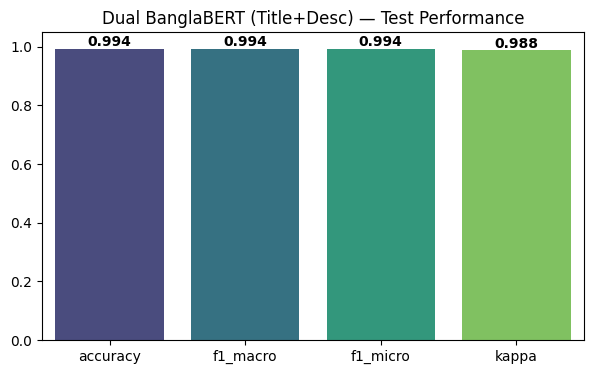

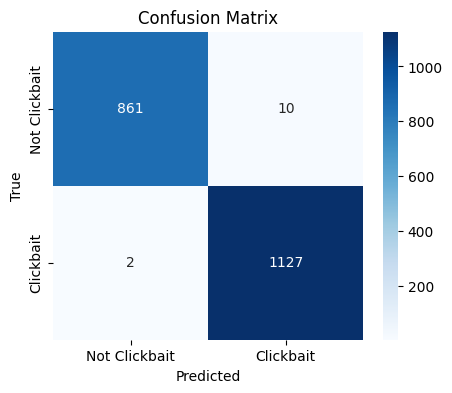

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1) Metrics bar chart ---
metrics_names = ["accuracy", "f1_macro", "f1_micro", "kappa"]
scores = [metrics[m] for m in metrics_names]

plt.figure(figsize=(7,4))
sns.barplot(x=metrics_names, y=scores, palette="viridis")
plt.title("Dual BanglaBERT (Title+Desc) — Test Performance")
plt.ylim(0.0,1.05)
for i,v in enumerate(scores):
    plt.text(i, v+0.01, f"{v:.3f}", ha="center", fontweight="bold")
plt.show()

# --- 2) Confusion matrix heatmap ---
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Clickbait","Clickbait"], yticklabels=["Not Clickbait","Clickbait"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()